In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sklearn
import sys
from scipy.stats import norm
import warnings
from scipy.stats.stats import pearsonr
from pandas import ExcelWriter
warnings.filterwarnings("ignore")

In [ ]:
#Version 3.1 : Remove Dummy Entries Updated - MVK

In [42]:
def clean(data):

    #REMOVE DUMMY ENTRIES ***Version 3.1 Update***
    
    data = data[~data['SubCategory'].str.contains("DummyCategory")]

    #DUPLICATE USERS CHECK
    dc = data[['UserName','QuestionId']]
    dups = dc[dc.duplicated()]
    
    if(dups.empty == False):
        print('\n\n\033[1mDuplicate values in data! Check the following usernames:\033[0m')
        print(set(dups['UserName']))
        sys.exit()


    pc = data.pivot_table(index = "UserName", columns = "QuestionId", values = ["OptionNumber", "TimeTaken"])
    pc.columns.names = (None, None)

    #REMOVE USERS BASED ON TIME
    for user, time in pc['TimeTaken'].iterrows():
        count = 0
        #questions = time.count()
        for i in time:
            if i < 2: count += 1
        if count>20: #Condition Subject to Change
            pc.drop(user, inplace=True)

    #SAME ANSWER CHECK
    for user, option in pc['OptionNumber'].iterrows():
        count = [0,0,0,0,0]
        thresh = 0.8*option.count() #Threshold Subject to Change

        for i in option:
            if i==1:
                count[0] += 1
            if i==2:
                count[1] += 1
            if i==3:
                count[2] += 1
            if i==4:
                count[3] += 1
            if i==5:
                count[4] += 1

        if (count[0] > thresh) or (count[1] > thresh) or (count[2] > thresh) or (count[3] > thresh) or (count[4] > thresh):
            pc.drop(user, inplace=True)

    #PEOPLE TO KEEP
    keep = list(pc.index)

    pivot = data.pivot_table(index = "UserName", columns = ["Category", "SubCategory", "QuestionId"], values = "Marks")
    pivot.columns.names = (None, None, None)

    #KEEPING APPROVED USERS
    for user, item in pivot.iterrows():
        if user not in keep:
            pivot.drop(user, inplace= True)
            
    pivot.fillna(0, inplace=True)
    return pivot

In [27]:
def normal(db):
    
    print('\n\n\033[1m- NORMS -\033[0m')
    
    dft = pd.DataFrame.copy(db)
    
    print("\n\n\033[1mNumber of Students = \033[0m", len(dft.index))
    
    heads = list(dft.columns.levels[0])
    lvls = list(dft.columns.levels[1])
       
    final_result = pd.DataFrame(index = dft.index, columns = ['remove1', 'remove2'])
    
    final_result.loc['Mean'] = 0
    final_result.loc['Std Dev'] = 0
    
    for j in heads:
        
        for k in lvls:
            
            df = dft[j][k]
            
            
            if not list(df.columns):
                continue
            
            
            original = df.sum(axis=1)
            marks = original.asobject
            marks.sort()
            marks = list(marks)
            x = np.asarray(marks)

            mu = np.mean(marks)
            sigma = np.std(marks)

            graph = plt.hist(marks, 10, facecolor='white', edgecolor='black', linewidth=1.5)[0]
            plt.clf()

            height = max(graph)

            original = original.to_frame()
            original.columns = ['Marks']

            perf = ["" for i in range(len(marks))]

            for i in range(len(perf)):

                val = original.iloc[i]['Marks']

                if val>(mu-sigma) and val<(mu+sigma):
                    perf[i] = 3

                if val>(mu+sigma) and val<(mu+(2*sigma)):
                    perf[i] = 4

                if val<(mu-sigma) and val>(mu-(2*sigma)):
                    perf[i] = 2

                if val>(mu+(2*sigma)):
                    perf[i] = 5

                if val<(mu-(2*sigma)):
                    perf[i] = 1
            
            perf.append(round(mu))
            perf.append(round(sigma))           
            final_result[k] = perf
            
        df = dft[j]
        
        original = df.sum(axis=1)
        marks = original.asobject
        marks.sort()
        marks = list(marks)
        x = np.asarray(marks)

        mu = np.mean(marks)
        sigma = np.std(marks)

        graph = plt.hist(marks, 10, facecolor='white', edgecolor='black', linewidth=1.5)[0]
        plt.clf()

        height = max(graph)

        plt.figure(figsize=(10,7))
        plt.title(j, fontsize=20)
        plt.hist(marks, 10, facecolor='white', edgecolor='black', linewidth=1.5)
        plt.plot(x, mlab.normpdf(x, mu, sigma)*height*height, c='r')
        plt.axvline(mu, linestyle='dashdot', linewidth=2.5)
        plt.axvline(mu-sigma, linestyle='dashed', linewidth=2.5)
        plt.axvline(mu+sigma, linestyle='dashed', linewidth=2.5)
        plt.axvline(mu-2*sigma, linestyle='dotted', linewidth=3)
        plt.axvline(mu+2*sigma, linestyle='dotted', linewidth=3)
        plt.ylabel('No. of Students', fontsize=15)
        plt.xlabel('Marks', fontsize=15)

        plt.text(s=round(mu), x=mu, y=height, fontsize=15, color='m')
        plt.text(s=round(mu-sigma), x=(mu-sigma), y=height, fontsize=15)
        plt.text(s=round(mu+sigma), x=(mu+sigma), y=height, fontsize=15)
        plt.text(s=round(mu-2*sigma), x=(mu-2*sigma), y=height, fontsize=15)
        plt.text(s=round(mu+2*sigma), x=(mu+2*sigma),y=height, fontsize=15)

        plt.show()

        original = original.to_frame()
        original.columns = ['Marks']

        perf = ["" for i in range(len(marks))]

        for i in range(len(perf)):

            val = original.iloc[i]['Marks']

            if val>(mu-sigma) and val<(mu+sigma):
                perf[i] = 3

            if val>(mu+sigma) and val<(mu+(2*sigma)):
                perf[i] = 4

            if val<(mu-sigma) and val>(mu-(2*sigma)):
                perf[i] = 2

            if val>(mu+(2*sigma)):
                perf[i] = 5

            if val<(mu-(2*sigma)):
                perf[i] = 1
                
        perf.append(round(mu))
        perf.append(round(sigma))
                
        final_result[j] = perf
        
    df = dft

    original = df.sum(axis=1)
    marks = original.asobject
    marks.sort()
    marks = list(marks)
    x = np.asarray(marks)

    mu = np.mean(marks)
    sigma = np.std(marks)

    graph = plt.hist(marks, 10, facecolor='white', edgecolor='black', linewidth=1.5)[0]
    plt.clf()

    height = max(graph)

    plt.figure(figsize=(10,7))
    plt.title('Total', fontsize=20)
    plt.hist(marks, 10, facecolor='white', edgecolor='black', linewidth=1.5)
    plt.plot(x, mlab.normpdf(x, mu, sigma)*height*height, c='r')
    plt.axvline(mu, linestyle='dashdot', linewidth=2.5)
    plt.axvline(mu-sigma, linestyle='dashed', linewidth=2.5)
    plt.axvline(mu+sigma, linestyle='dashed', linewidth=2.5)
    plt.axvline(mu-2*sigma, linestyle='dotted', linewidth=3)
    plt.axvline(mu+2*sigma, linestyle='dotted', linewidth=3)
    plt.ylabel('No. of Students', fontsize=15)
    plt.xlabel('Marks', fontsize=15)

    plt.text(s=round(mu), x=mu, y=height, fontsize=15, color='m')
    plt.text(s=round(mu-sigma), x=(mu-sigma), y=height, fontsize=15)
    plt.text(s=round(mu+sigma), x=(mu+sigma), y=height, fontsize=15)
    plt.text(s=round(mu-2*sigma), x=(mu-2*sigma), y=height, fontsize=15)
    plt.text(s=round(mu+2*sigma), x=(mu+2*sigma),y=height, fontsize=15)

    plt.show()

    original = original.to_frame()
    original.columns = ['Marks']

    perf = ["" for i in range(len(marks))]

    for i in range(len(perf)):

        val = original.iloc[i]['Marks']

        if val>(mu-sigma) and val<(mu+sigma):
            perf[i] = 3

        if val>(mu+sigma) and val<(mu+(2*sigma)):
            perf[i] = 4

        if val<(mu-sigma) and val>(mu-(2*sigma)):
            perf[i] = 2

        if val>(mu+(2*sigma)):
            perf[i] = 5

        if val<(mu-(2*sigma)):
            perf[i] = 1
            
    perf.append(round(mu))
    perf.append(round(sigma))
            
    final_result['Total'] = perf
    
    del final_result['remove1']
    del final_result['remove2']
    
    writer = ExcelWriter('Norms.xlsx')
    final_result.to_excel(writer,'Sheet1')
    writer.save()

In [28]:
def cat_cronbach(af):

    df = pd.DataFrame.copy(af)
    nlvls = df.columns.levels[0]

    ndf = pd.DataFrame()

    for i in nlvls:

        if not list(df[i].columns):
            continue

        ndf = pd.concat([ndf, df[i]], axis = 1)

    ndf['Total'] = ndf.sum(axis=1)

    #Items is list of columns
    items = list(ndf.columns)

    #Index values of respective columns
    num = len(items) - 1   

    #Adding row Variance and recalculating variance
    ndf.loc['Variance'] = ndf.var(axis=0)

    results = pd.DataFrame(columns = ["alpha if removed"])

    if(num>=3):

        for i in range(0, num):

            working = pd.DataFrame.copy(ndf)

            working.drop(items[i], axis=1, inplace=True)

            l=len(working.columns) 

            working[items[l]] = 0

            working.drop('Variance', axis=0, inplace=True)

            #print(working)

            working[items[l]] = working.sum(axis=1)  

            working.loc['Variance'] = working.var(axis=0)

            wi = len(working.columns) - 1

            alpha = (wi/(wi-1)) * (1 - sum(working.loc['Variance'][0:wi])/(working.loc['Variance'][wi]))

            #print(working)

            results.loc[items[i]] = alpha

            #print("Cronbach's alpha if \033[1m", items[i], "\033[0m deleted = ", alpha)

        print(results)

        alpha =  (num/(num-1)) * (1 - sum(ndf.loc['Variance'][0:num])/(ndf.loc['Variance'][num]))
        print("\033[1mCategory Cronbach's Alpha = ", alpha, '\033[0m')

    elif (num==2): 
        print("\n!!\033[1mOnly following two items left.\033[0m : ")
        for i in range(num):
            print('-> ',items[i])
        print("Skipping calculation for item if deleted.")
        alpha =  (num/(num-1)) * (1 - sum(ndf.loc['Variance'][0:num])/(ndf.loc['Variance'][num]))
        print("\033[1mCategory Cronbach's Alpha = ", alpha, '\033[0m')

    elif (num<2): print("!!\033[1mLess than two items left.\033[0m Skipping all calculations.")



In [29]:
def cronbach(af):
    
    print('\n\n')
    print("\033[1m-CRONBACH'S ALPHA-\033[0m")
    
    #Create dataframe for function to work with
    
    dft = pd.DataFrame.copy(af)
    
    heads = list(dft.columns.levels[0])
    lvls = list(dft.columns.levels[1])
    
    
    for j in heads:
        
        print('\n')
        print("\033[1m*", j, "*\033[0m")
        
        cat_cronbach(dft[j])
    
        for k in lvls:

            df = dft[j][k]

            if not list(df.columns):
                continue

            print('\n')
            print('\033[1m', k, '\033[0m')

            df['Total'] = df.sum(axis=1)

            #Items is list of columns
            items = list(df.columns)

            #Index values of respective columns
            num = len(items) - 1   

            #Adding row Variance and recalculating variance
            df.loc['Variance'] = df.var(axis=0)

            results = pd.DataFrame(columns = ["alpha if removed"])

            if(num>=3):

                for i in range(0, num):

                    working = pd.DataFrame.copy(df)

                    working.drop(items[i], axis=1, inplace=True)

                    l=len(working.columns) 

                    working[items[l]] = 0

                    working.drop('Variance', axis=0, inplace=True)

                    #print(working)

                    working[items[l]] = working.sum(axis=1)  

                    working.loc['Variance'] = working.var(axis=0)

                    wi = len(working.columns) - 1

                    alpha = (wi/(wi-1)) * (1 - sum(working.loc['Variance'][0:wi])/(working.loc['Variance'][wi]))

                    #print(working)

                    results.loc[items[i]] = alpha

                    #print("Cronbach's alpha if \033[1m", items[i], "\033[0m deleted = ", alpha)

                print(results)

                alpha =  (num/(num-1)) * (1 - sum(df.loc['Variance'][0:num])/(df.loc['Variance'][num]))
                print("\033[1mSubcat Cronbach's Alpha = ", alpha, '\033[0m')

            elif (num==2): 
                print("\n!!\033[1mOnly following two items left.\033[0m : ")
                for i in range(num):
                    print('-> ',items[i])
                print("Skipping calculation for item if deleted.")
                alpha =  (num/(num-1)) * (1 - sum(df.loc['Variance'][0:num])/(df.loc['Variance'][num]))
                print("\033[1mSubcat Cronbach's Alpha = ", alpha, '\033[0m')

            elif (num<2): print("!!\033[1mLess than two items left.\033[0m Skipping all calculations.")

In [30]:
def diff(data):
    
    print('\n\n')
    print('\033[1m-DIFFICULTY-\033[0m')
    
    #Find MAX possible value in marks
    
    heads = list(data.columns.levels[0])
    lvls = list(data.columns.levels[1])
    
    marks = []
    
    for i in heads:
        for j in lvls:
            for k in data[i][j].iterrows():
                if not k[1].empty:
                    marks.append(max(k[1]))
    
    correct = max(set(marks))
    
    no_of_items = 0
    
    for i in heads:
        for j in lvls:
            for k in data[i][j]:
                no_of_items += 1
            
    no_of_users = len(pivot.index)

    result = pd.DataFrame(columns = ['Item', 'Difficulty'], index = range(no_of_items))

    m = -1
    
    for i in heads:
        
        for j in lvls:

            for j in data[i][j].iteritems():
                m += 1
                result['Item'][m] = j[0]
                marks_all = j[1]
                count = 0

                for t in marks_all:
                    #print(t)
                    if t==correct:
                        count += 1
                difficulty = count/no_of_users
                result['Difficulty'].iloc[m] = round(difficulty, 4)

    result.set_index('Item', inplace=True)
    result.index.name = None
    print(result.to_string())


In [31]:
def discr(data):
    
    print('\n\n')
    print('\033[1m-DISCRIMINATION-\033[0m')
    
    heads = list(data.columns.levels[0])
    lvls = list(data.columns.levels[1])
    
    for j in heads:
        
        print('\n')
        print('\033[1m*', j, '*\033[0m')
        
        for k in lvls:
                
                df = data[j][k]
                
                if not list(df.columns):
                    continue

                
                print('\n')
                print('\033[1m', k, '\033[0m')

                #Items is list of columns
                items = list(df.columns)

                results = pd.DataFrame(index = items, columns = ["Discrimination"])

                #Index values of respective columns
                num = len(items) - 1   

                for i in range(0, num+1):

                    working = pd.DataFrame.copy(df)

                    marks = working[items[i]].asobject

                    working.drop(items[i], axis=1, inplace=True)

                    total = working.sum(axis=1).asobject

                    disc = round(pearsonr(marks, total)[0], 5)

                    results.loc[items[i]] = disc

                #Adding row Variance and recalculating variance

                print(results)

Enter path to xlsx file
C:\Users\Administrator\Downloads\Passion-Raw.xlsx


Which of the following would you like to include in the report: 

1. Normal Curve
2. Cronbach's Alpha
3. Difficulty
4. Discrimination

 Enter number against preferences separated by spaces. 
1 2 3 4


- NORMS -


Number of Students =  178


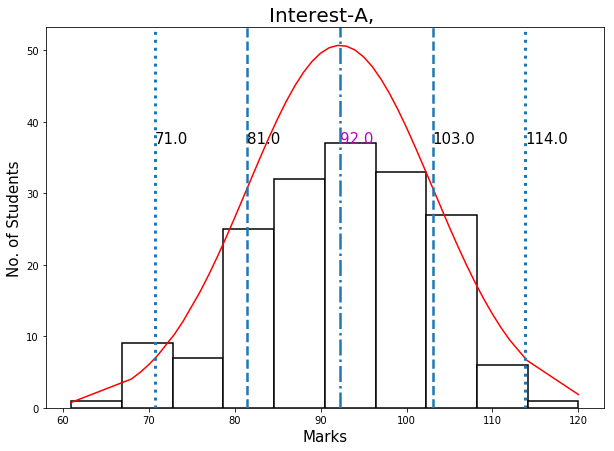

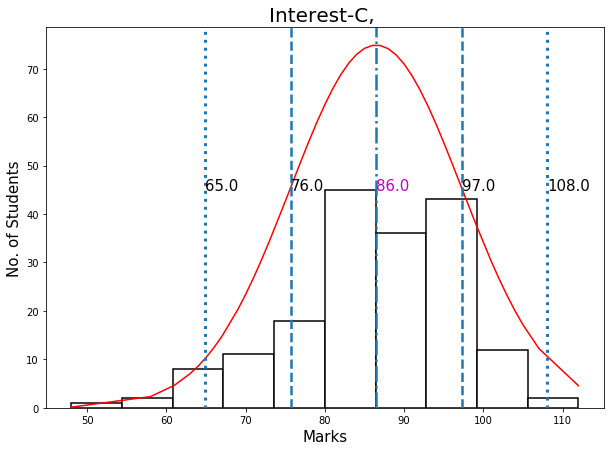

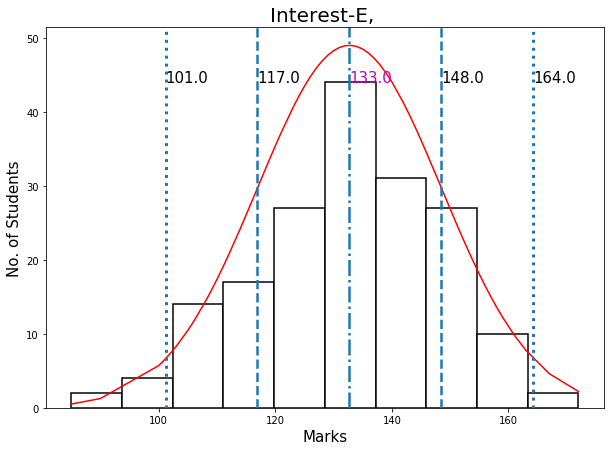

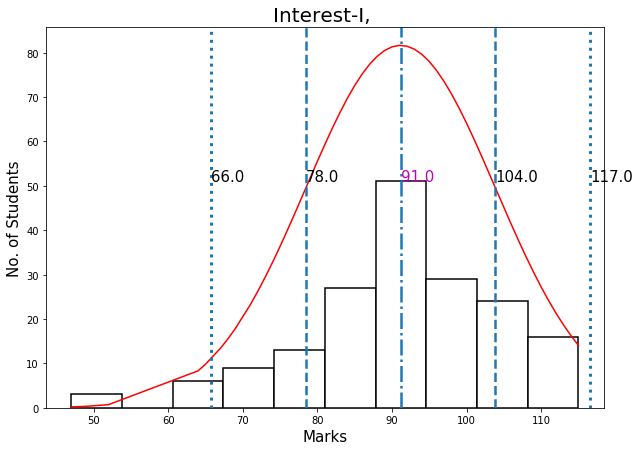

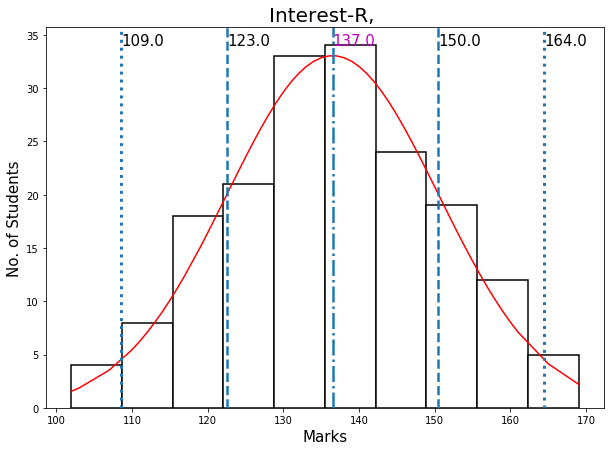

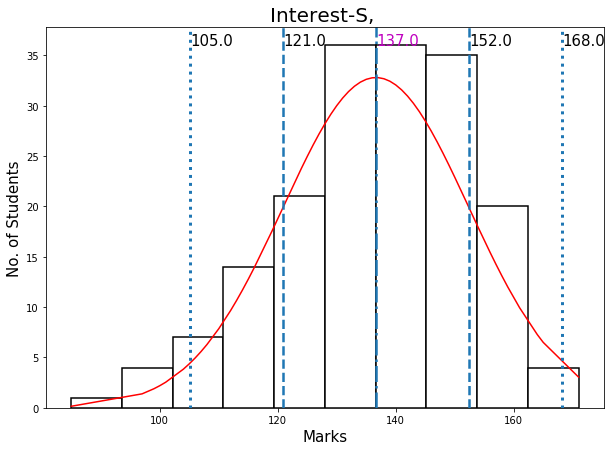

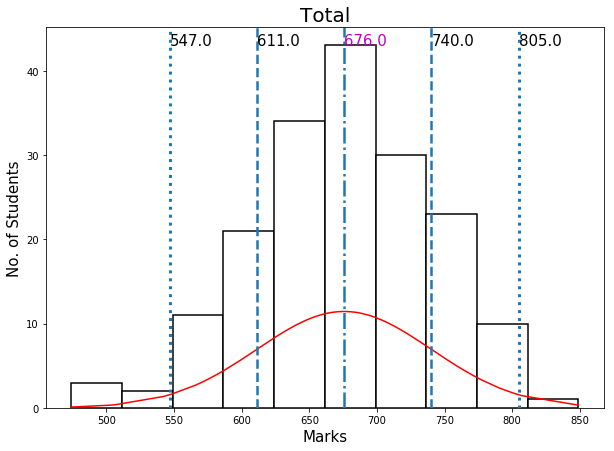




-CRONBACH'S ALPHA-


* Interest-A,  *
      alpha if removed
3021          0.786781
3086          0.786024
3125          0.781644
3139          0.786798
3142          0.777936
3152          0.777743
3048          0.783700
3068          0.776532
3108          0.778369
3128          0.772162
3133          0.783305
3147          0.783132
3016          0.784016
3037          0.780987
3049          0.780140
3093          0.797090
3095          0.782402
3169          0.784198
3013          0.794892
3030          0.785445
3033          0.785099
3123          0.779403
3130          0.782953
3172          0.786906
Category Cronbach's Alpha =  0.790482770444 


 Interest-A1,  
      alpha if removed
3021          0.507206
3086          0.499312
3125          0.453728
3139          0.444898
3142          0.361935
3152          0.428192
Subcat Cronbach's Alpha =  0.497382453764 


 Interest-A2,  
      alpha if removed
3048          0.682378
3068          0.712539
3108          0.683268
3128   

 Interest-R2,  
      alpha if removed
2999          0.450294
3020          0.485231
3052          0.340491
3106          0.463106
3131          0.497045
3146          0.470346
Subcat Cronbach's Alpha =  0.500613333924 


 Interest-R3,  
      alpha if removed
3040          0.593862
3044          0.550708
3102          0.620292
3103          0.645672
3104          0.614471
3167          0.555545
Subcat Cronbach's Alpha =  0.642417461665 


 Interest-R4,  
      alpha if removed
2992          0.560600
3014          0.530600
3026          0.567277
3053          0.489212
3082          0.528844
3164          0.516720
Subcat Cronbach's Alpha =  0.57736122022 


 Interest-R5,  
      alpha if removed
3001          0.448709
3004          0.393176
3012          0.342184
3042          0.391695
3091          0.306907
3155          0.402904
Subcat Cronbach's Alpha =  0.426612396175 


 Interest-R6,  
      alpha if removed
3096          0.684487
3110          0.649427
3119          0.679878
3126 

 Interest-R2,  
     Discrimination
2999        0.26521
3020        0.19994
3052        0.43989
3106        0.24083
3131         0.1684
3146        0.22473


 Interest-R3,  
     Discrimination
3040          0.387
3044        0.48479
3102        0.31145
3103         0.2403
3104        0.32984
3167        0.48618


 Interest-R4,  
     Discrimination
2992        0.25727
3014        0.31848
3026        0.24536
3053        0.41971
3082        0.32367
3164        0.35381


 Interest-R5,  
     Discrimination
3001        0.10413
3004        0.18991
3012        0.27991
3042        0.19165
3091         0.3257
3155        0.16858


 Interest-R6,  
     Discrimination
3096        0.40897
3110         0.5178
3119        0.42988
3126        0.48022
3137        0.50171
3162         0.3495


* Interest-S,  *


 Interest-S1,  
     Discrimination
2993        0.11742
3000        0.21753
3031        0.19328
3112        0.38061
3148        0.24181
3171        0.07685


 Interest-S2,  
     Discriminati

In [43]:
#C:/Users/Vihan/Desktop/Data/IntScale/Duplicate_demo.xlsx
#C:/Users/Vihan/Desktop/Data/IntScale/Data_demo.xlsx
#C:/Users/Vihan/Desktop/Data/IntScale/DC.xlsx

path = input("Enter path to xlsx file\n")

raw = pd.read_excel(path)

pivot = clean(raw)

preference = input("\n\nWhich of the following would you like to include in the report: \n\n1. Normal Curve\n2. Cronbach's Alpha\n3. Difficulty\n4. Discrimination\n\n Enter number against preferences separated by spaces. \n")
preference = preference.split()

if ('1' in preference):
    normal(pivot)

if ('2' in preference):
    cronbach(pivot)

if ('3' in preference):
    diff(pivot)

if ('4' in preference):
    discr(pivot)
    
    


In [ ]:
raw = pd.read_excel(C:\Users\Administrator\Downloads\Passion-Raw.xlsx)
pivot = clean(raw
cronbach(pivot)